In [1]:
!pip install kagglehub

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00


In [3]:
!pip install opencv-python-headless

In [4]:
import kagglehub
import pandas as pd
import numpy as np
import os
from ultralytics import YOLO
import cv2
import shutil
import yaml
from google.colab.patches import cv2_imshow

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
print("Downloading dataset:")
path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")

Using Colab cache for faster access to the 'driver-drowsiness-dataset-ddd' dataset.


In [6]:
print("Dataset downloaded to:", path)

Dataset downloaded to: /kaggle/input/driver-drowsiness-dataset-ddd


In [7]:
for root, dir, files in os.walk(path):
  print(f"Folders : {root}")

Folders : /kaggle/input/driver-drowsiness-dataset-ddd
Folders : /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)
Folders : /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy
Folders : /kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy


In [8]:
print("\nExploring dataset structure:")
for root, dirs, files in os.walk(path):
  for file in files:
    print(os.path.join(root, file))

Streaming output truncated to the last 5000 lines.
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/P0727.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/ZC1296.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/I1162.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/N0432.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A1121.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/A0004.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/ZC0259.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/N0016.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/X1148.png
/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Drowsy/N0057.png
/kaggle/input/dri

In [9]:
data = []
base_path = os.path.join(path, "Driver Drowsiness Dataset (DDD)")

# Collectng image paths + labels
data= []
for root, dirs, files in os.walk(base_path):
  for file in files:
    if file.lower().endswith(('.png')):
      label = os.path.basename(root)
      filepath = os.path.join(root, file)
      data.append({'filepath': filepath, 'label': label})

In [10]:
df = pd.DataFrame(data)
df.head()

,filepath,label
0,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
1,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
2,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
3,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
4,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy


In [11]:
df['label'].value_counts()

,count
label,
Drowsy,22348
Non Drowsy,19445


In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

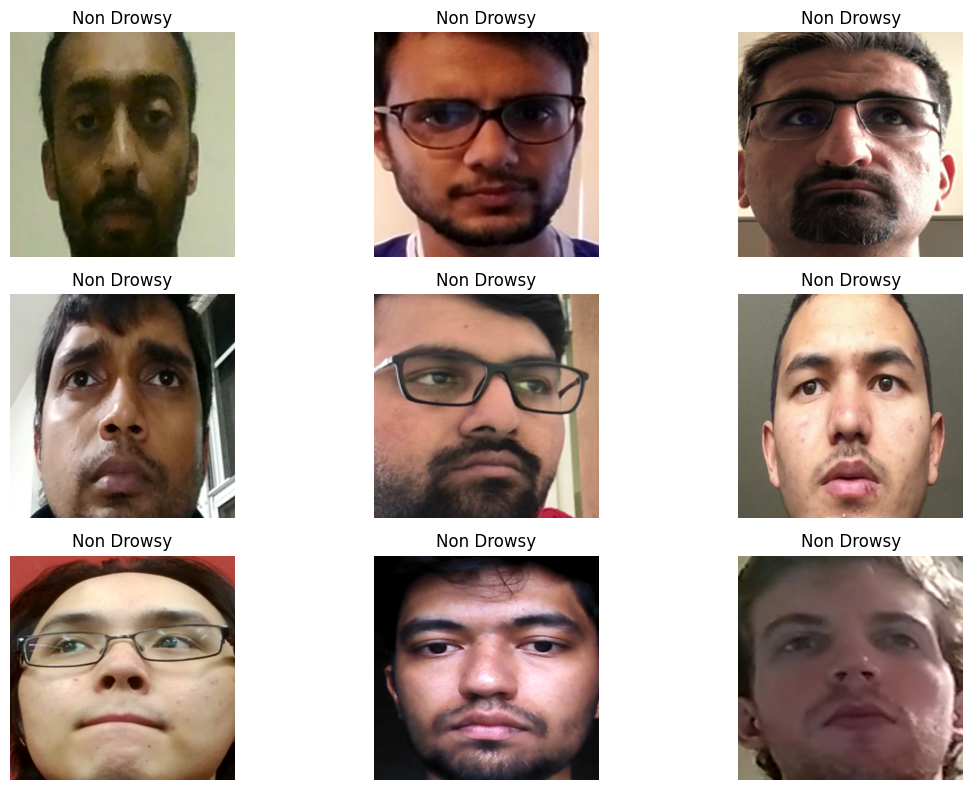

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    img = mpimg.imread(df['filepath'][i])
    ax.imshow(img)
    ax.set_title(df['label'][i])
    ax.axis("off")

plt.tight_layout()
plt.show()

In [14]:
df.isna().sum()

,0
filepath,0
label,0


In [15]:
df.duplicated().sum()

np.int64(0)

In [16]:
df.head()

,filepath,label
0,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
1,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
2,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
3,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
4,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy


In [17]:
Drowsy = df[df['label'] == 'Drowsy'].copy()

In [18]:
Drowsy.head()

,filepath,label
19445,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy
19446,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy
19447,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy
19448,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy
19449,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy


In [19]:
NotDrowsy = df[df['label'] == 'Non Drowsy'].copy()

In [20]:
def extract_subject(path):
    fname = os.path.basename(path)
    if fname[0] in ["Z", "z"]:
      return fname[0:2]
    else:
      return fname[0]

In [21]:
Drowsy["subject"] = Drowsy["filepath"].apply(extract_subject)

In [22]:
NotDrowsy["subject"] = NotDrowsy["filepath"].apply(extract_subject)

In [23]:
print(sorted(Drowsy['subject'].unique()))
print(sorted(NotDrowsy['subject'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'ZA', 'ZB', 'ZC']
['a', 'b', 'c', 'd', 'e', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'x', 'y', 'za', 'zb', 'zc']


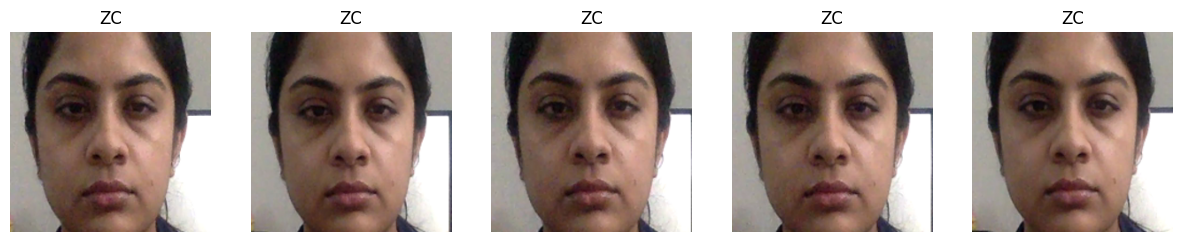

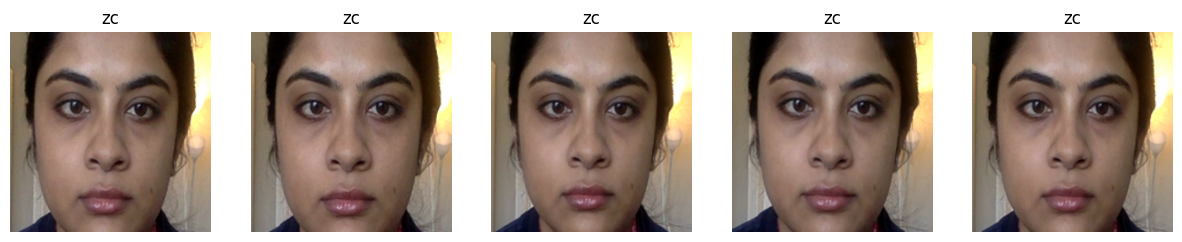

In [24]:
import matplotlib.pyplot as plt
import cv2

def show_subject_samples(df, subject, n=5):
    """Show n sample images for a given subject."""
    samples = df[df["subject"] == subject]["filepath"].sample(n, random_state=42)

    plt.figure(figsize=(15,3))
    for i, path in enumerate(samples):
        img = cv2.imread(path)[:,:,::-1]
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{subject}")
    plt.show()

#F,Z,T
show_subject_samples(Drowsy, "ZC", n=5)
show_subject_samples(NotDrowsy, "zc", n=5)

In [25]:
print("Dowsy dataframe : ",Drowsy.shape)
print("Not Drowsy DataFrame : ",NotDrowsy.shape)

Dowsy dataframe :  (22348, 3)
Not Drowsy DataFrame :  (19445, 3)


In [26]:
NotDrowsy['subject'] = NotDrowsy['subject'].str.upper()

In [27]:
print(sorted(Drowsy['subject'].unique()))
print(sorted(NotDrowsy['subject'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'ZA', 'ZB', 'ZC']
['A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y', 'ZA', 'ZB', 'ZC']


In [28]:
all_subjects = set(Drowsy['subject'].unique()).union(set(NotDrowsy['subject'].unique()))
len(all_subjects)

28

In [29]:
train_sub = set(['F','T'])
val_sub = set([])

remaining_subjects = list(all_subjects - train_sub - val_sub)
len(remaining_subjects)

26

In [30]:
import random

In [31]:
random.seed(42)
random.shuffle(remaining_subjects)

split_point = int(len(remaining_subjects) * 0.8)
train_sub.update(remaining_subjects[:split_point])
val_sub.update(remaining_subjects[split_point:])

In [32]:
print(sorted(train_sub))
print(sorted(val_sub))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'N', 'O', 'Q', 'S', 'T', 'U', 'X', 'Y', 'ZA', 'ZB']
['M', 'P', 'R', 'V', 'W', 'ZC']


In [33]:
def assign_split(subj):
    if subj in val_sub:
        return "val"
    elif subj in train_sub:
        return "train"
    else:
        return "unknown"

In [34]:
Drowsy['split'] = Drowsy['subject'].apply(assign_split)

In [35]:
NotDrowsy['split'] = NotDrowsy['subject'].apply(assign_split)

In [36]:
NotDrowsy['split'].unique()

array(['train', 'val'], dtype=object)

In [37]:
Drowsy['split'].unique()

array(['train', 'val'], dtype=object)

In [38]:
df = pd.concat([Drowsy, NotDrowsy], axis=0)

In [39]:
df

,filepath,label,subject,split
19445,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy,E,train
19446,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy,Y,train
19447,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy,A,train
19448,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy,U,train
19449,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy,R,val
...,...,...,...,...
19440,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy,W,val
19441,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy,D,train
19442,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy,A,train
19443,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy,K,train


In [40]:
label_map = {"Non Drowsy": 0, "Drowsy": 1}
df["label"] = df["label"].map(label_map)

In [41]:
train = df[df['split']=='train'].copy()
val = df[df['split']=='val'].copy()

In [42]:
print(train.shape)
print(val.shape)

(32720, 4)
(9073, 4)


In [43]:
print(train['label'].value_counts())
print(val['label'].value_counts())

label
1    17243
0    15477
Name: count, dtype: int64
label
1    5105
0    3968
Name: count, dtype: int64


In [44]:
train.drop(columns=['subject', 'split'], inplace=True)
val.drop(columns=['subject', 'split'], inplace=True)

In [45]:
train

,filepath,label
19445,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,1
19446,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,1
19447,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,1
19448,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,1
19450,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,1
...,...,...
19438,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,0
19439,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,0
19441,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,0
19442,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,0


# Data Augmentation

In [63]:
import albumentations as A
import cv2
import os

In [70]:
# Define augmentation transformations (without ToTensor/Normalize)
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.7),
    A.Rotate(limit=15, p=0.5),
    A.GaussianBlur(p=0.6),
    A.RandomGamma(p=0.3),
    A.Resize(224, 224),
])

In [71]:
train.loc[0,"filepath"]

'/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/e0604.png'

In [72]:
img_path = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/Non Drowsy/e0604.png'

In [73]:
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [74]:
augmented = transform(image=image)
aug_img = augmented["image"]
print(augmented.keys())

dict_keys(['image'])


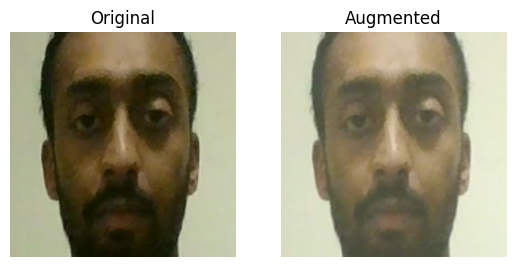

In [75]:
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(aug_img)
plt.title("Augmented")
plt.axis("off")

plt.show()

In [80]:
base_dir = "yolo_classification."

# Ensure folders exist
for split, split_df in [("train", train), ("val", val)]:
    for label in split_df['label'].unique():
        os.makedirs(f"{base_dir}/{split}/{label}", exist_ok=True)

    # Copy images
    for _, row in split_df.iterrows():
        src = row['filepath']
        dest = f"{base_dir}/{split}/{row['label']}/{os.path.basename(src)}"
        if not os.path.exists(dest):
            shutil.copy(src, dest)

print("YOLO classification dataset structure created!")

YOLO classification dataset structure created!


In [81]:
for split in ["train", "val"]:
    print(f"\n{split.upper()}:")
    split_path = os.path.join(base_dir, split)
    for label in os.listdir(split_path):
        label_path = os.path.join(split_path, label)
        if os.path.isdir(label_path):
            n_images = len(os.listdir(label_path))
            print(f"  Class {label}: {n_images} images")


TRAIN:
  Class 0: 15477 images
  Class 1: 17243 images

VAL:
  Class 0: 3968 images
  Class 1: 5105 images


In [82]:
def augment_and_save(input_dir, n_aug=1):

    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        for img_name in os.listdir(cls_path):
            img_path = os.path.join(cls_path, img_name)
            image = cv2.imread(img_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Generate augmented copies
            for i in range(n_aug):
                augmented = transform(image=image)
                aug_img = augmented["image"]  # NumPy array (H, W, C)

                aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
                aug_name = f"aug_{i}_{img_name}"
                cv2.imwrite(os.path.join(cls_path, aug_name), aug_img_bgr)

In [83]:
train_path = os.path.join(base_dir, "train")

# Augment training images only
augment_and_save(train_path, n_aug=2)

print("\nAugmentation finished!")


Augmentation finished!


In [87]:
split_path = os.path.join(base_dir, "train")
for label in os.listdir(split_path):
    label_path = os.path.join(split_path, label)
    if os.path.isdir(label_path):
        n_images = len(os.listdir(label_path))
        print(f"  Class {label}: {n_images} images")

  Class 0: 46431 images
  Class 1: 51729 images


# Structuring For YOLO:

Training YOLOv8n -> nano model

In [84]:
import time
model = YOLO("yolov8n-cls.pt")  # nano model

start_time = time.time()

results = model.train(
    data= base_dir,  # dataset root
    epochs=10,
    imgsz=224,  # every image is resized to 224×224 pixels.
    batch=32,
    workers=4,           # Parallel data loading
    device=0,            # Force GPU
    amp=True,            # Mixed precision
)

end_time = time.time()
print('-'*200)
print(f"Training completed in: {(end_time - start_time)/60:.2f} minutes")
print(f"Average per epoch: {(end_time - start_time)/60/10:.2f} minutes")

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_classification., degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pr

KeyboardInterrupt: 

In [ ]:
# Evaluating the mode
model.val()

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-cls summary (fused): 47 layers, 5,436,690 parameters, 0 gradients, 12.0 GFLOPs
train: /content/driver_dataset/train... found 31159 images in 2 classes ✅ 
val: /content/driver_dataset/val... found 10634 images in 2 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2345.5±834.3 MB/s, size: 68.8 KB)
val: Scanning /content/driver_dataset/val... 10634 images, 0 corrupt: 100% ━━━━━━━━━━━━ 10634/10634 22.7Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 333/333 7.9it/s 41.9s
                   all      0.664          1
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/train32


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d1613709b50>
curves: []
curves_results: []
fitness: 0.8317660391330719
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6635320782661438, 'metrics/accuracy_top5': 1.0, 'fitness': 0.8317660391330719}
save_dir: PosixPath('/content/runs/classify/train32')
speed: {'preprocess': 0.1074556983250648, 'inference': 0.9170289512892702, 'loss': 0.00037992119683305357, 'postprocess': 0.0008553026142585954}
task: 'classify'
top1: 0.6635320782661438
top5: 1.0